# Main Focus of the Notebook: Exploratory Data Analysis and Dropping detected spots which are most likely noise

Note: 
For this notebook please read all the markdowns before each cell as this is an iterative notebook and its desirable to read instructions before running that cell for the first time you are running it. 

In [1]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import napari
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import zarr
import dask.array as da
import os 
sys.path.append('../src/')

from detections_preprocessing import hist_plot, box_whisker_plot

plt.rcParams["font.family"] = ""

### Do not change the code in the cell below 

In [2]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'all_detections_channel3.pkl'
input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = 'cleaned_spots_intensities_c3_all.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [3]:
spots_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')
z2.shape

(130, 3, 75, 258, 275)

In [4]:
def calculate_whiskers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    return lower_whisker, upper_whisker

# Assuming spots_df is your DataFrame
columns = ['amplitude', 'sigma_x', 'sigma_y', 'sigma_z']
whiskers = {}

for col in columns:
    lower_whisker, upper_whisker = calculate_whiskers(spots_df[col])
    whiskers[col] = {'lower_whisker': lower_whisker, 'upper_whisker': upper_whisker}

amplitude_upper_limit = whiskers['amplitude']['upper_whisker']
sigmax_upper_limit = whiskers['sigma_x']['upper_whisker']
sigmay_upper_limit = whiskers['sigma_y']['upper_whisker']
sigmaz_upper_limit = whiskers['sigma_z']['upper_whisker']

sigmax_lower_limit = whiskers['sigma_x']['lower_whisker']
sigmay_lower_limit = whiskers['sigma_y']['lower_whisker']
sigmaz_lower_limit = whiskers['sigma_z']['lower_whisker']

# NAPARI VISUALISATION
## ALL POINTS VISUALISATION

The purpose of the visualisation below is to give you an idea of the performance of the detection algorithm and you can decide if you want to drop certain points using this visualisation. In the cell after napari visualisation you will be guided on how to drop certain points if you want. However, note that if you think that many spots are not detected it is recommended to go back to notebook 01 and adjust the spot_intensity parameter or others over there. 

In this notebook you can only drop points not add points, so as mentioned above, if you think spots have been missed out during detection you have to go back to the previous notebook. 

In [6]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['Channel 1', 'Channel 2', 'Channel 3'])
#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

points_layer = viewer.add_points(spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'All Spots', face_color = 'white', symbol = 'ring')

In [7]:
print(f'the upper limit for amplitude is {amplitude_upper_limit}')
print(f'the upper limit for sigma x  is {sigmax_upper_limit}')
print(f'the upper limit for sigma y is {sigmay_upper_limit}')
print(f'the upper limit for sigma z is {sigmaz_upper_limit}')

the upper limit for amplitude is 320.0
the upper limit for sigma x  is 2.0
the upper limit for sigma y is 3.5
the upper limit for sigma z is 5.5


## The above values are used to determine the cutoff values 
## You can adjust the tolerance values below, a sample explanation on how to adjust the values: 

From the napari visualisation if you think very bright patches which are clusters and not spots you can decrease the amplitude_tolerance to a value less than 1.0 for instance 0.8 this will reduce the amplitude_upper_limit to 80% of the actual value and then you can view in napari that those clusters are not detected as spots. If you think spots detected are fine then leave it to 1.0. However, if you think detections are correct you can increase the amplitude cut_tolerance to 1.2. 

This is an iterative process and you can try different tolerance values to come up with the right parameters. 

Once you run the below cells. Now napari will have three layers apart from the movie layers. 

1. The first layer All Spots has all the points detected 
2. The second layer is Dropped Spots, it shows you the spots you have dropped and you can change this by adjusting tolerance values 
3. The third layer is Cleaned Spots, these are the spots that you retain and will be used for downstream analysis. This can also give you a good idea of your cutoff values and if any adjustment is needed 


Once you change and rerurn the filtering step below it is recommended to delete previous layers in Napari otherwise new layers with [1] in the end will be created as the layer is using the same name. 

In [8]:
# Define the conditions

## User can change the belowe parameters 
# tolerance for limits 
amplitude_tolerance = 1.0
sigmax_tolerance = 1.0
sigmay_tolerance = 1.0
sigmaz_tolerance = 1.0 

#dropping spots above certain threshold 
condition_1 = spots_df['amplitude'] <= amplitude_upper_limit * amplitude_tolerance 


#dropping spots above certain standard dev in x
condition_2 = spots_df['sigma_x'] <= sigmax_upper_limit * sigmax_tolerance


#dropping spots above certain standard dev in y 
condition_3 = spots_df['sigma_y'] <= sigmay_upper_limit * sigmay_tolerance


#dropping spots above certain standard dev in z
condition_4 = spots_df['sigma_z'] <= sigmaz_upper_limit * sigmaz_tolerance


## No need to change the below conditions 

#dropping spots below certain standard dev in x
condition_5 = spots_df['sigma_x'] >= sigmax_lower_limit

#dropping spots below certain standard dev in y
condition_6 = spots_df['sigma_y'] >= sigmay_lower_limit

#dropping spots below certain standard dev in z
condition_7 = spots_df['sigma_z'] >= sigmaz_lower_limit

#dropping spots out of bounds of z axis 
condition_8 = spots_df['mu_z'] >= 0
condition_9 = spots_df['mu_z'] <= z2.shape[2]

#dropping spots out of bounds of x axis 
condition_10 = spots_df['mu_x'] >= 0
condition_11 = spots_df['mu_x'] <= z2.shape[4]

#dropping spots out of bounds of y axis 
condition_12 = spots_df['mu_y'] >= 0
condition_13 = spots_df['mu_y'] <= z2.shape[3]


# Combine the conditions using logical AND (&)
cleaned_spots_df = spots_df[condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13].reset_index(drop = True)


In [9]:
dropped_spots = spots_df[~(condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13)]

In [10]:
#Visualising the dropped spots and the cleaned spots 
points_layer = viewer.add_points(dropped_spots[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Dropped Spots', face_color = 'blue', symbol = 'ring')

points_layer = viewer.add_points(cleaned_spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Cleaned Spots', face_color = 'red', symbol = 'ring')

# Final Graphs
## The red dotted line shows the value where cutoff has been set. This means that all values above the cutoff have been dropped 

5.5


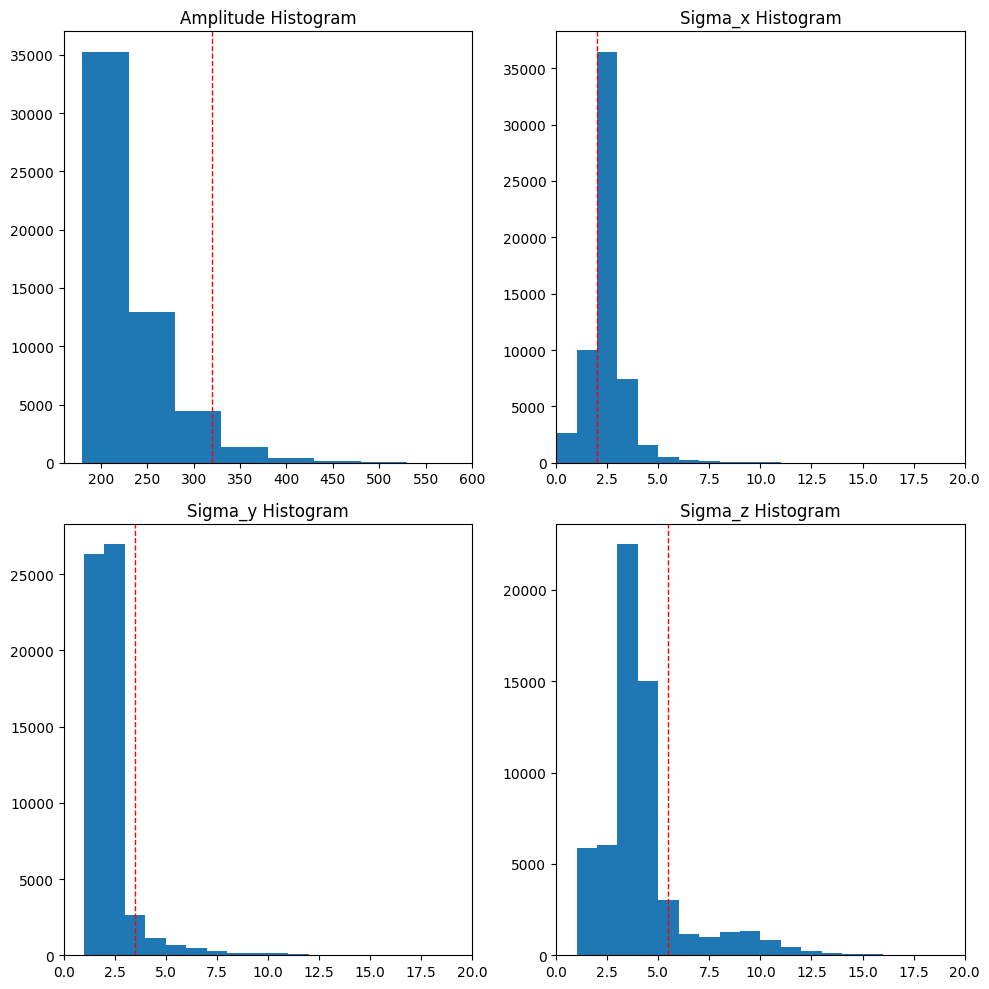

In [11]:

amplitude_cutoff = amplitude_upper_limit * amplitude_tolerance 
sigmax_cutoff = sigmax_upper_limit * sigmax_tolerance
sigmay_cutoff = sigmay_upper_limit * sigmay_tolerance
sigmaz_cutoff = sigmaz_upper_limit * sigmaz_tolerance
print(sigmaz_cutoff)

# Assuming cleaned_spots_df is your DataFrame with columns 'Amplitude', 'sigma_x', 'sigma_y', 'sigma_z'

# Set up subplots as a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Histogram for Amplitude with bins of size 50 starting from 180
axes[0].hist(spots_df['amplitude'].dropna(), bins=range(180, int(spots_df['amplitude'].max()) + 50, 50))
axes[0].axvline(amplitude_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[0].set_title('Amplitude Histogram')

# Histogram for sigma_x with bins of size 1 starting from 0
axes[1].hist(spots_df['sigma_x'].dropna(), bins=range(0, int(spots_df['sigma_x'].max()) + 1, 1))
axes[1].axvline(sigmax_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[1].set_xlim(0, 20)
axes[1].set_title('Sigma_x Histogram')

# Histogram for sigma_y with bins of size 1 starting from 0
axes[2].hist(spots_df['sigma_y'].dropna(), bins=range(0, int(spots_df['sigma_y'].max()) + 1, 1))
axes[2].axvline(sigmay_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[2].set_xlim(0, 20)
axes[2].set_title('Sigma_y Histogram')

# Histogram for sigma_z with bins of size 1 starting from 0
axes[3].hist(spots_df['sigma_z'].dropna(), bins=range(0, int(spots_df['sigma_z'].max()) + 1, 1))
axes[3].axvline(sigmaz_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[3].set_xlim(0, 20)
axes[3].set_title('Sigma_z Histogram')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [12]:
# Save the DataFrame to a Pickle file
cleaned_spots_df.to_pickle(output_directory_full)